In [8]:
import os
import cv2
import glob
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from skimage.feature import hog
from sklearn.decomposition import IncrementalPCA, PCA
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer

In [2]:
import tensorflow as tf
DEVICES=tf.config.experimental.list_physical_devices()
print('GPU Availability : ',tf.test.is_gpu_available())
tf.config.experimental.set_memory_growth(device=DEVICES[1],enable=True)     

GPU Availability :  True


In [3]:
basedir='./HOG_NN/mataji/Female/7/'

In [4]:
def HOG(imagePath):
    H=[]
    image = cv2.imread(imagePath)
    #image = cv2.bitwise_not(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.3, tileGridSize=(8,8))
    img = clahe.apply(gray)
    imS = cv2.resize(img, (161, 182)) 
    (H, hogImage) = hog(imS, orientations=1, pixels_per_cell=(7,7),cells_per_block=(2,2), transform_sqrt=True, block_norm="L1", visualize=True) 
    #Data Normalisation (Normalising HOG Features)
    H*=10
    return H

In [5]:
%%script False
data = []
labels = []
traindir='./path/Dataset/ghoshaala/MatajiGaushala'#Enter the Train Directory
for directory_path in glob.glob(traindir+"/*"):
    label = directory_path.split("\\")[-1]
    print(label)
    for img_path in glob.glob(os.path.join(directory_path,"*.png")):
        #print(img_path)
        A = HOG(img_path)
        data.append(A)
        labels.append(label)
np.save(basedir+'data.npy',data)
np.save(basedir+'labels.npy',labels)

Couldn't find program: 'False'


In [6]:
data=np.load(basedir+'data.npy')
labels=np.load(basedir+'labels.npy')
from sklearn import preprocessing
from tensorflow.keras.utils import to_categorical
le = preprocessing.LabelEncoder()
le.fit(labels)
toh= le.transform(labels)
OHE_labels=to_categorical(toh)
n_classes=OHE_labels.shape[1]
print("Classes ",n_classes,)
print("Data    ",data.shape)
print("labels  ",labels.shape)
print("One Hot Labels ",OHE_labels.shape)

Classes  2840
Data     (42599, 2200)
labels   (42599,)
One Hot Labels  (42599, 2840)


Text(0, 0.5, 'Cum variance')

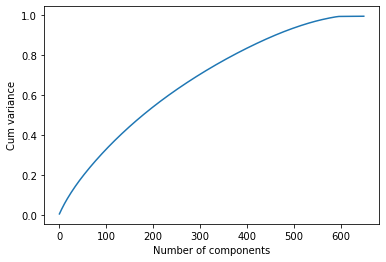

In [5]:
#%%script false
# First verfiy the ideal number of PCA components to not lose much information. 
# Try to retain 90% information, so look where the curve starts to flatten.
# Remember that the n_components must be lower than the number of rows or columns (features)
pca_test = PCA(n_components=650) 
pca_test.fit(data)
#pca_test.fit(data)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cum variance")

In [10]:
n_PCA_components = 300
pca = PCA(n_components=n_PCA_components)
train_PCA = pca.fit_transform(data)

In [11]:
#%%script false
import pickle as pk
pk.dump(pca, open(basedir+"pca_data.pkl","wb"))

In [11]:
#Memory cleaning by removing unwanted variable 
data=[]

In [12]:
model = Sequential()
model.add(InputLayer(input_shape=(n_PCA_components,)))
model.add(Dense(1008,activation='relu'))
model.add(Dense(400,activation='sigmoid'))
model.add(Dense(2048,activation='relu'))
model.add(Dense(n_classes, kernel_regularizer=tf.keras.regularizers.l2(0.001),activation='softmax'))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1008)              505008    
_________________________________________________________________
dense_1 (Dense)              (None, 400)               403600    
_________________________________________________________________
dense_2 (Dense)              (None, 2048)              821248    
_________________________________________________________________
dense_3 (Dense)              (None, 2840)              5819160   
Total params: 7,549,016
Trainable params: 7,549,016
Non-trainable params: 0
_________________________________________________________________


In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
#model.load_weights(basedir+"model.h5")

checkpoint = ModelCheckpoint(basedir+"model.h5", 
                             monitor='categorical_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             #save_freq=1
                             )
optamizer= Adam(
    learning_rate=0.0001,
    beta_1=0.99,
    beta_2=0.999,
    epsilon=1e-10,
    amsgrad=True,
    name="Adam", 
    )

early = EarlyStopping(monitor='categorical_accuracy', 
                      min_delta=0, 
                      patience=18, 
                      verbose=1, 
                      mode='auto')
model.compile(
    optimizer=optamizer,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'])

import datetime
start = datetime.datetime.now()
#Fit the model. Do not forget to use on-hot-encoded Y values. 
model.fit(train_PCA,OHE_labels,
          epochs=5,
          verbose=1,
          callbacks=[checkpoint]
          )
end = datetime.datetime.now()
print("Total execution time with PCA is: ", end-start)

Train on 42599 samples
Epoch 1/5
42592/42599 [============================>.] - ETA: 0s - loss: 0.3952 - categorical_accuracy: 0.9371
Epoch 00001: categorical_accuracy improved from -inf to 0.93716, saving model to ./HOG_NN/mataji/Female/7/model.h5
42599/42599 [==============================] - 238s 6ms/sample - loss: 0.3951 - categorical_accuracy: 0.9372
Epoch 2/5
42592/42599 [============================>.] - ETA: 0s - loss: 0.1246 - categorical_accuracy: 0.9956
Epoch 00002: categorical_accuracy improved from 0.93716 to 0.99559, saving model to ./HOG_NN/mataji/Female/7/model.h5
42599/42599 [==============================] - 242s 6ms/sample - loss: 0.1246 - categorical_accuracy: 0.9956
Epoch 3/5
42592/42599 [============================>.] - ETA: 0s - loss: 0.0987 - categorical_accuracy: 0.9965
Epoch 00003: categorical_accuracy improved from 0.99559 to 0.99648, saving model to ./HOG_NN/mataji/Female/7/model.h5
42599/42599 [==============================] - 2641s 62ms/sample - loss: 0.